In [132]:
import numpy as np
import os
import scipy.stats as st
import scipy
import matplotlib.pyplot as plt
import pickle as pkl
import PGanalysis

In [2]:
# load the two spot stimulation data generated using the two-spot processor
os.chdir(r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\breath-triggered_sequence_aPCx\two_spot_stim\phase_shift\controls\summary_data')
rec_230225 = np.load('230225_control.npy', allow_pickle = True)[0]
rec_230227 = np.load('230227_control.npy', allow_pickle = True)[0]
rec_230301 = np.load('230301_control.npy', allow_pickle = True)[0]
rec_230302 = np.load('230302_control.npy', allow_pickle = True)[0]
rec_230303 = np.load('230303_control.npy', allow_pickle = True)[0]
rec_230324 = np.load('230324_control.npy', allow_pickle = True)[0]

In [133]:
expt_metadata_path = r'Z:\robin\expt_sets\pattern_stim\metadata\220830\P137_2022_8_30_111325'
with open(expt_metadata_path, 'rb') as f:
    expt_metadata = pkl.load(f)

In [3]:
# make a list of all experiments
reclist = [rec_230225, rec_230227, rec_230301, rec_230302, rec_230303, rec_230324]

In [4]:
# set the indices for each trial type in order from delta t (A-->B) = 70 to delta t (A-->B) = -70
indices = np.concatenate((np.flipud(np.arange(0,15)),np.arange(16,30)))
# set the indices for single spit presentation as a function of time since inhalation
single_spot_indices = np.concatenate((np.flipud(np.arange(30,45)),np.arange(46,60)))

In [129]:
indices

array([14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [130]:
single_spot_indices

array([44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [111]:
# find cells that are significantly activated by at least one of the delta t conditions
bonf_corr_alpha = .05/len(indices) # bonferroni corrected alpha value 
bonf_corr_act = []
for rec in reclist:
    for cell in range(rec['pvals'].shape[0]):
        if (np.sum((np.where(rec['pvals'][cell,indices]<bonf_corr_alpha)[0]))>0) & (np.sum((np.where(rec['auroc'][cell,indices]>.5)[0]))>0):
            bonf_corr_act.append(1)
        else:
            bonf_corr_act.append(0)

In [112]:
# for each experiment, spike_counts is an n_cells x n_conditions x n_trials matrix containing spike counts over the first 300ms of the trial
spike_counts = rec_230225['spike_counts']
for rec in reclist[1:]:
     spike_counts = np.concatenate((spike_counts, rec['spike_counts']),0)

In [113]:
# perform an anova to identify significantly tuned cells 
tuning = np.empty(spike_counts.shape[0])
tuning_curve_counts = spike_counts[:,indices,:]
# set a label for each trial
labels = np.repeat([indices],spike_counts.shape[2])
for idx, cell in enumerate(tuning_curve_counts):
    tun = PGanalysis.find_temp_tuning(tuning_curve_counts[idx,:,:].ravel(),labels, alpha = .025)
    tuning[idx] = tun

In [114]:
# find cells that are both significantly tuned and significantly activated 
tuned_cells = np.where(~np.isnan(tuning))[0]
resp_cells = np.where(np.array(bonf_corr_act)>0)[0]
tuned_resp_cells = []
for cell in resp_cells:
    if cell in tuned_cells:
        tuned_resp_cells.append(cell)

In [115]:
print('num cells significantly activated = ' + str(len(resp_cells)) + ' out of ' + str(len(bonf_corr_act)))
print('Percentage of cells significantly activated = ' +str(len(np.where(np.array(bonf_corr_act) == 1)[0])/len(bonf_corr_act)*100))
print('num cells significantly tuned = ' + str(len(tuned_resp_cells)) + ' out of ' + str(len(resp_cells)))
print('Percentage of activated cells significantly tuned = ' + str(len(tuned_resp_cells)/len(np.where(np.array(bonf_corr_act) == 1)[0])*100))

num cells significantly activated = 67 out of 521
Percentage of cells significantly activated = 12.859884836852206
num cells significantly tuned = 60 out of 67
Percentage of activated cells significantly tuned = 89.55223880597015


In [116]:
# get the baseline subtracted PSTHs and concatenate across experiments
baseline_indices = np.where((rec_230225['PSTH_timepoints']>-.5) & (rec_230225['PSTH_timepoints']<0))[0]
response_indices = np.where((rec['PSTH_timepoints']>-.05) & (rec['PSTH_timepoints']<.3))[0]
baseline_psth = rec_230225['psth_all'][:,:,:,baseline_indices]
baseline_psth_mean_bytrial = np.mean(baseline_psth,3)
baseline_sub_bytrial = np.mean( rec_230225['psth_all'][:,:,:,response_indices],3) - baseline_psth_mean_bytrial
baseline_sub_psth_by_trial = baseline_sub_bytrial
for rec in reclist[1:]:
    baseline_psth = rec['psth_all'][:,:,:,baseline_indices]
    baseline_psth_mean_bytrial = np.mean(baseline_psth,3)
    baseline_sub_bytrial = np.mean(rec['psth_all'][:,:,:,response_indices],3) - baseline_psth_mean_bytrial
    baseline_sub_psth_by_trial = np.concatenate((baseline_sub_psth_by_trial, baseline_sub_bytrial),0)

In [117]:
n_trials = baseline_sub_psth_by_trial.shape[2]
n_stim = len(indices)

In [168]:
def plot_real_and_predicted_curves(cell, baseline_sub_psth_by_trial, indices, single_spot_indices, n_trials, n_stim, filt_width = 5, font_size = 15):
    test = baseline_sub_psth_by_trial[cell,:,:]
    test = test[indices,:]
    all_mov_mean_y = np.empty((n_trials,n_stim))
    all_mov_mean_y_combine = np.empty((n_trials,n_stim))
    x_valid = np.arange(-70,75,5)
    filt_width = 5

    single_spot_indices_flip = np.concatenate((np.zeros(14)+30, np.zeros(15)+45)).astype(int)

    test_move = baseline_sub_psth_by_trial[cell,:]
    test_move = test_move[np.flipud(single_spot_indices),:]

    test_static = baseline_sub_psth_by_trial[cell,:,:]
    test_static = test_static[single_spot_indices_flip,:]

    test_all = test_move+test_static

    for trial in range(n_trials):
        y = test[:,trial]
        y_combine = test_all[:,trial]
        mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
        mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')

        all_mov_mean_y[trial,:] = mov_mean_y
        all_mov_mean_y_combine[trial,:] = mov_mean_y_combine

    mean_stim_resp = np.mean(all_mov_mean_y,0)
    mean_stim_resp_combine = np.mean(all_mov_mean_y_combine,0)
    CI = []
    CI_combine = []
    for stim in range(n_stim):
        data = all_mov_mean_y[:,stim]
        data_combine = all_mov_mean_y_combine[:,stim]
        t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
        t2 = np.abs(mean_stim_resp[stim]-t)
        CI.append(t2)
        t_combine = st.t.interval(alpha=0.95, df=len(data_combine)-1, loc=np.mean(data_combine), scale=st.sem(data_combine)) 
        t2_combine = np.abs(mean_stim_resp_combine[stim]-t_combine)
        CI_combine.append(t2)
    CI = np.array(CI)
    CI_combine = np.array(CI_combine)

    plt.plot(x_valid, np.mean(all_mov_mean_y,0), '-ko', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y,0), yerr = CI.T, color = 'k', linewidth = .5)
    plt.plot(x_valid, np.mean(all_mov_mean_y_combine,0), '-mo', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y_combine,0), yerr = CI_combine.T, color = 'purple', linewidth = .5)
    plt.ylim(-10,20)
    plt.xticks([-70,-35,0,35,70])
    plt.yticks([-10,-5,0,5,10,15,20])
    plt.ylabel('$\Delta$ firing rate (Hz)')
    plt.xlabel('$t_{a}-t_{b}$ (ms)')
    plt.title(str(cell))
    PGanalysis.axis_fixer(ratio = 1, size = font_size)

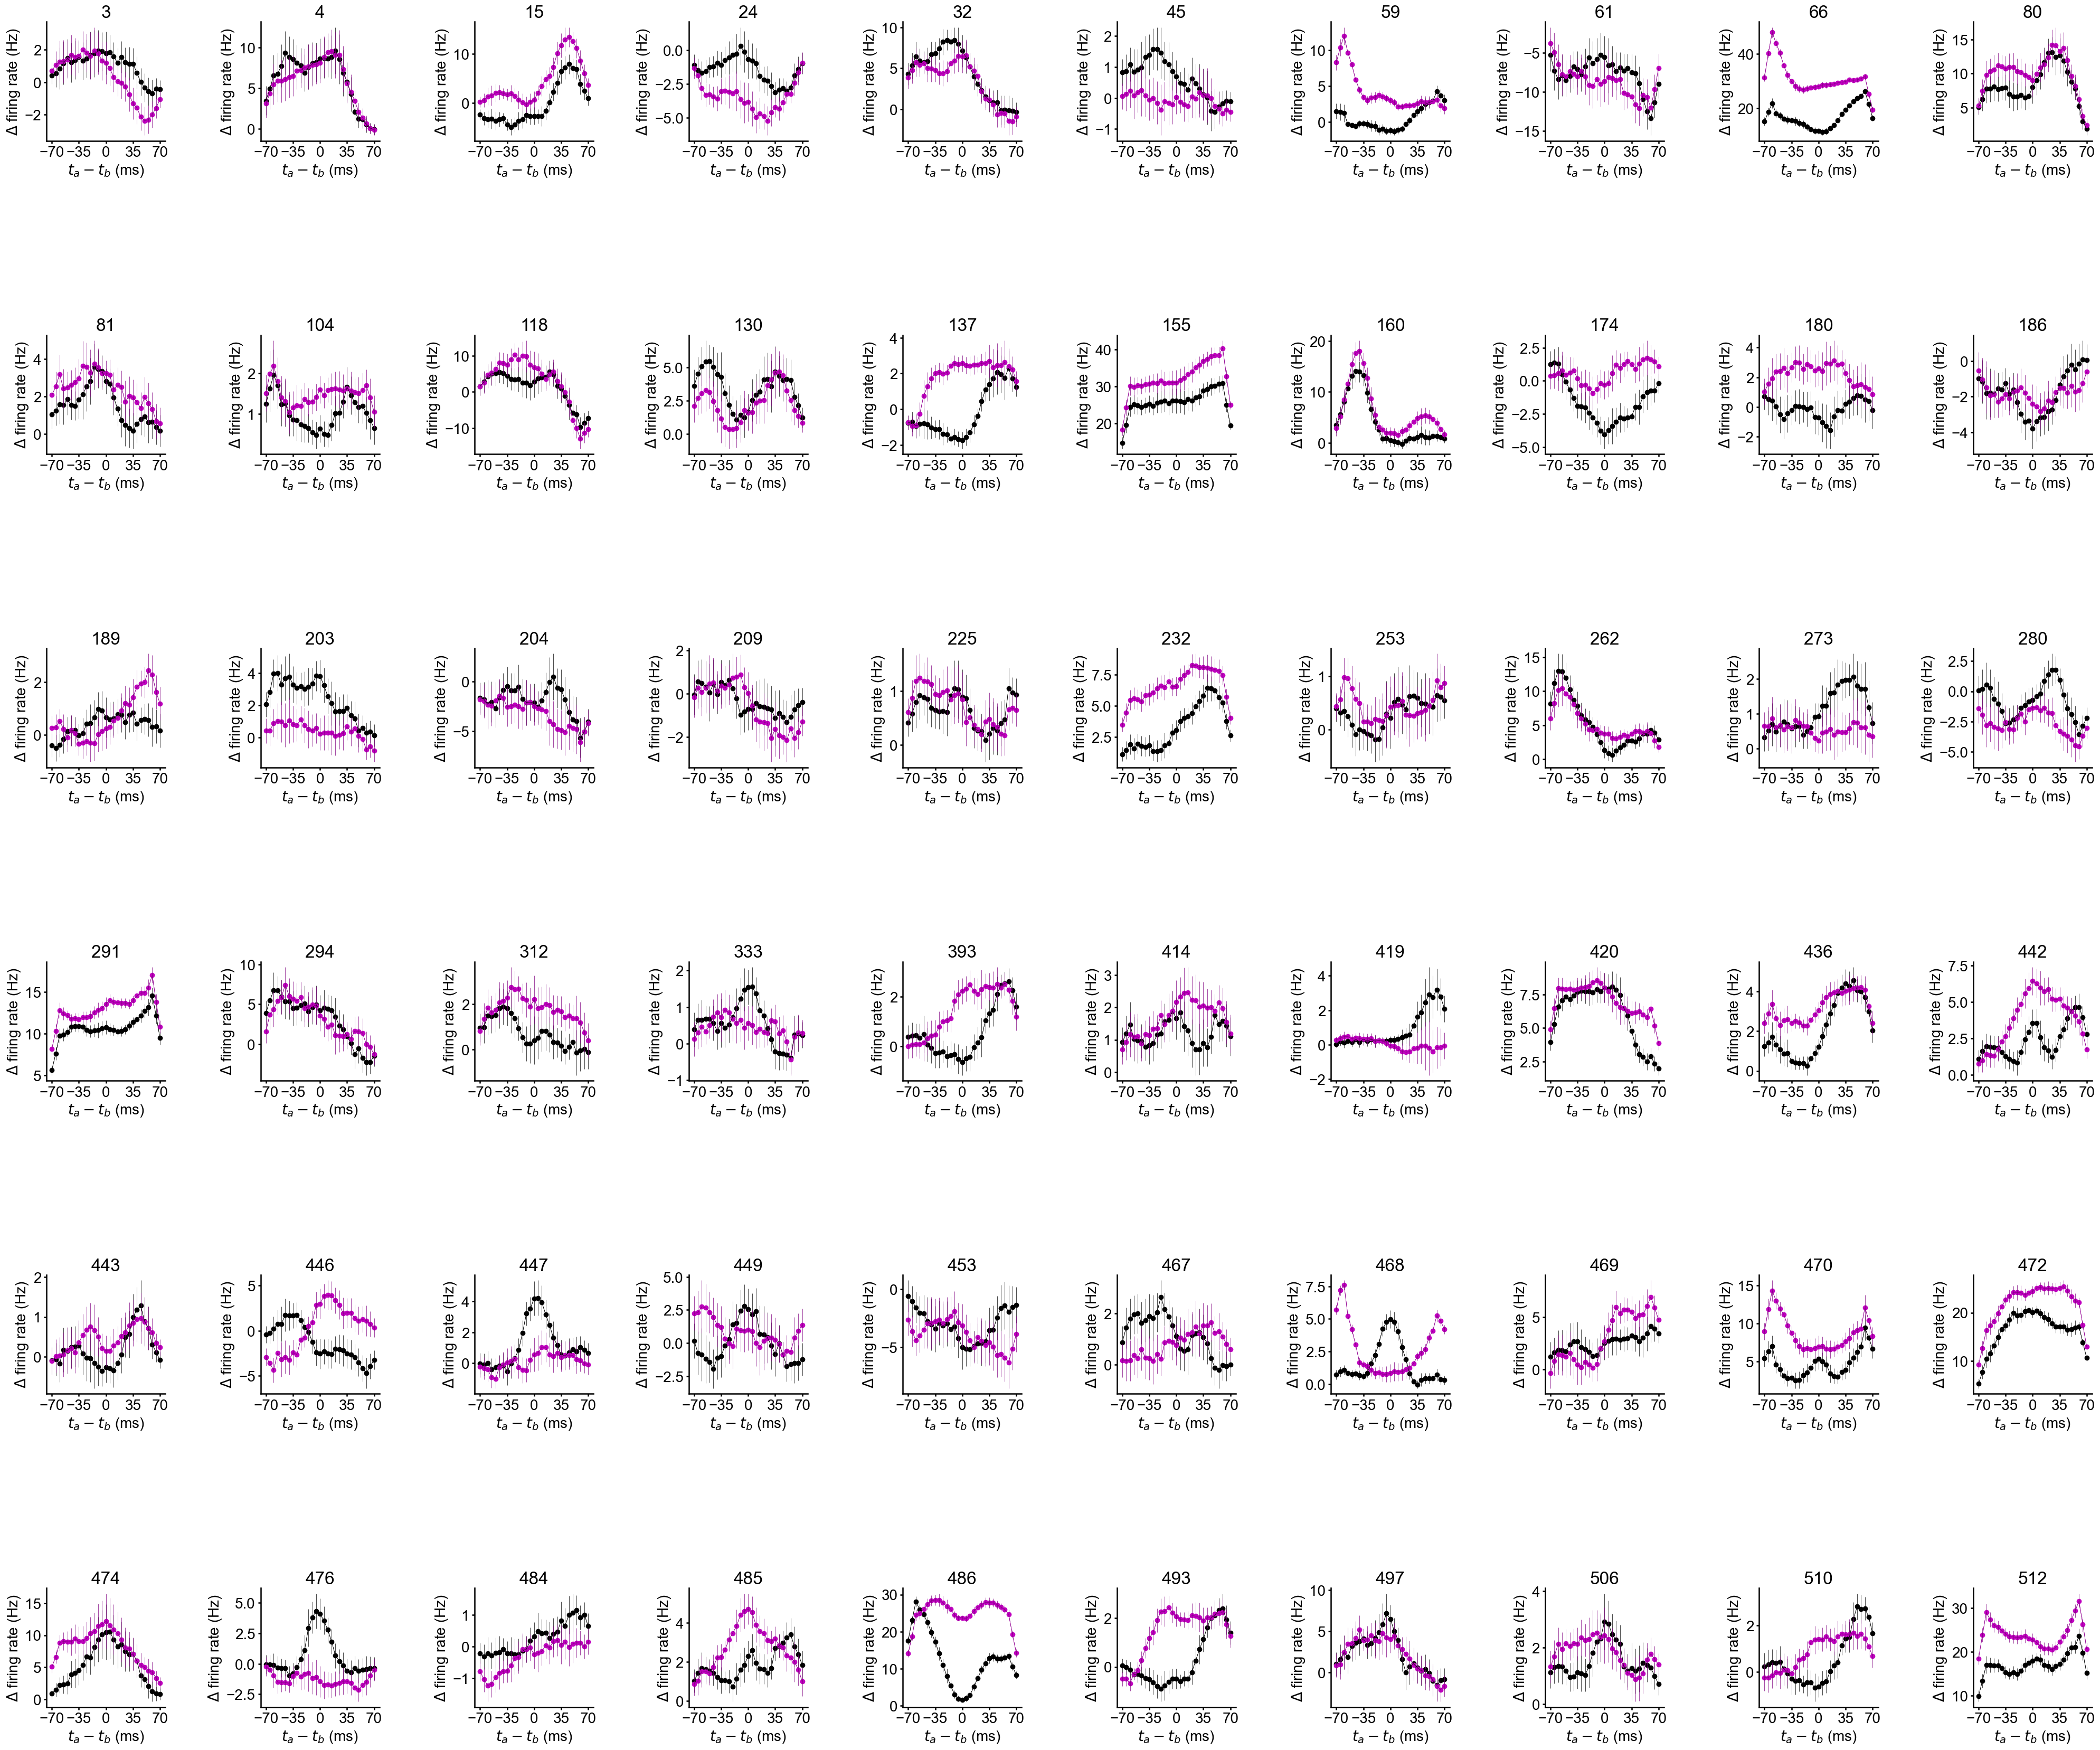

In [146]:
# plot all observed and predicted tuning curves for tuned and responsive cells 

plt.figure(figsize = (50,50))
for cell_n, cell in enumerate(tuned_resp_cells):
    
    plt.subplot(7,10,cell_n+1)
    
    test = baseline_sub_psth_by_trial[cell,:,:]
    test = test[indices,:]
    all_mov_mean_y = np.empty((n_trials,n_stim))
    all_mov_mean_y_combine = np.empty((n_trials,n_stim))
    x_valid = np.arange(-70,75,5)
    filt_width = 5

    single_spot_indices_flip = np.concatenate((np.zeros(14)+30, np.zeros(15)+45)).astype(int)

    test_move = baseline_sub_psth_by_trial[cell,:]
    test_move = test_move[np.flipud(single_spot_indices),:]

    test_static = baseline_sub_psth_by_trial[cell,:,:]
    test_static = test_static[single_spot_indices_flip,:]

    test_all = test_move+test_static

    for trial in range(n_trials):
        y = test[:,trial]
        y_combine = test_all[:,trial]
        mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
        mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')

        all_mov_mean_y[trial,:] = mov_mean_y
        all_mov_mean_y_combine[trial,:] = mov_mean_y_combine

    mean_stim_resp = np.mean(all_mov_mean_y,0)
    mean_stim_resp_combine = np.mean(all_mov_mean_y_combine,0)
    CI = []
    CI_combine = []
    for stim in range(n_stim):
        data = all_mov_mean_y[:,stim]
        data_combine = all_mov_mean_y_combine[:,stim]
        t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
        t2 = np.abs(mean_stim_resp[stim]-t)
        CI.append(t2)
        t_combine = st.t.interval(alpha=0.95, df=len(data_combine)-1, loc=np.mean(data_combine), scale=st.sem(data_combine)) 
        t2_combine = np.abs(mean_stim_resp_combine[stim]-t_combine)
        CI_combine.append(t2)
    CI = np.array(CI)
    CI_combine = np.array(CI_combine)

    plt.title(str(cell))
    plt.plot(x_valid, np.mean(all_mov_mean_y,0), '-ko', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y,0), yerr = CI.T, color = 'k', linewidth = .5)
    plt.plot(x_valid, np.mean(all_mov_mean_y_combine,0), '-mo', linewidth = .5)
    plt.errorbar(x_valid, np.mean(all_mov_mean_y_combine,0), yerr = CI_combine.T, color = 'purple', linewidth = .5)

    plt.xticks([-70,-35,0,35,70])
    
    plt.ylabel('$\Delta$ firing rate (Hz)')
    plt.xlabel('$t_{a}-t_{b}$ (ms)')
    PGanalysis.axis_fixer(ratio = 1, size = 20)

In [120]:
baseline_sub_mean_psth = np.mean(baseline_sub_psth_by_trial,2)

In [121]:
filt_width = 5 #each delta t is 5ms, so smoothing will occur over 25ms

coeffs = np.empty((len(tuned_resp_cells),2))
r_sq = np.empty(len(tuned_resp_cells))

mov_mean_y_all = np.empty((len(tuned_resp_cells), n_stim))
mov_mean_y_combine_all = np.empty((len(tuned_resp_cells), n_stim))

for i, cell in enumerate(tuned_resp_cells): 
    
    # get the tuning curve for each cell, and smooth it using a moving average over 25 ms.
    y = baseline_sub_mean_psth[cell,indices]
    mov_mean_y = np.convolve(y, np.ones(filt_width)/filt_width, mode='same')
    mov_mean_y_all[i,:] = mov_mean_y
    
    # get the predicted tuning curve by summing the responses to the single spot stimuli at each delta t condition 
    y_combine = baseline_sub_mean_psth[cell,np.flipud(single_spot_indices)]+baseline_sub_mean_psth[cell,single_spot_indices_flip]
    mov_mean_y_combine = np.convolve(y_combine, np.ones(filt_width)/filt_width, mode='same')
    mov_mean_y_combine_all[i,:] = mov_mean_y_combine
    
    # determine the % variance explained in the tuning curve by the phase of stimulation. 
    coeffs[i,:] = np.polyfit(mov_mean_y_combine, mov_mean_y,1)
    ss_tot = np.sum((mov_mean_y - np.mean(mov_mean_y))**2)
    ss_res = np.sum((mov_mean_y-(coeffs[i,0]*mov_mean_y_combine + coeffs[i,1]))**2)
    r_sq[i] = 1 -(ss_res/ss_tot)

In [122]:
simul_index = np.where(indices == 0)[0]

In [123]:
# get the 95% confidence interval for change in firing rate in the simultaneous (delta t = 0) stimulation condition for (A and B) and (A) + (B)
cint_y = st.t.interval(alpha=0.95, df=len(mov_mean_y_all[:,simul_index])-1, loc=np.mean(mov_mean_y_all[:,simul_index]), scale=st.sem(mov_mean_y_all[:,simul_index])) 
cint_y_combined = st.t.interval(alpha=0.95, df=len(mov_mean_y_combine_all[:,simul_index])-1, loc=np.mean(mov_mean_y_combine_all[:,simul_index]), scale=st.sem(mov_mean_y_combine_all[:,simul_index])) 

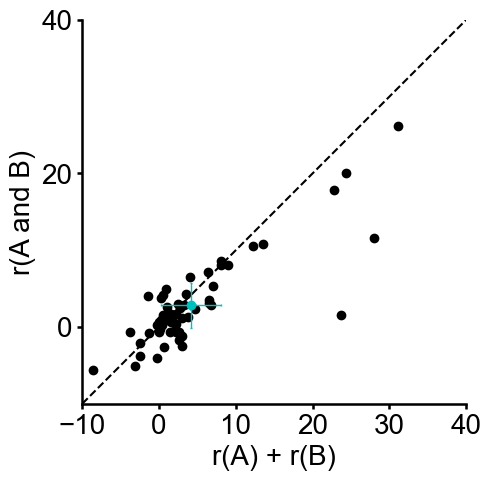

In [124]:
# for each cell, plot the change in firing rate in the simultaneous (delta t = 0) stimulation condition for (A and B) and (A) + (B)
plt.plot(mov_mean_y_combine_all[:,simul_index], mov_mean_y_all[:,simul_index], 'ko', zorder = 1)
plt.errorbar(np.mean(mov_mean_y_combine_all[:,simul_index]), np.mean(mov_mean_y_all[:,simul_index]), xerr = cint_y_combined[1]-cint_y_combined[0], yerr = cint_y[1]-cint_y[0], fmt = 'o', capsize = 1, elinewidth = 1, capthick = 1, zorder = 10, color = 'c')
plt.ylim(-10,40)
plt.xlim(-10,40)
plt.plot([-10,40],[-10,40],'k--')
plt.xticks(np.arange(-10,50,10))
plt.ylabel('r(A and B)')
plt.xlabel('r(A) + r(B)')
PGanalysis.axis_fixer(ratio = 1, size = 30)

In [125]:
# perform a significance test to determine whether firing rates are significantly higher or lower than predicted by the sum of individual spots
scipy.stats.ttest_1samp(mov_mean_y_combine_all[:,simul_index]-mov_mean_y_all[:,simul_index],0)

Ttest_1sampResult(statistic=array([2.58832213]), pvalue=array([0.01212476]))

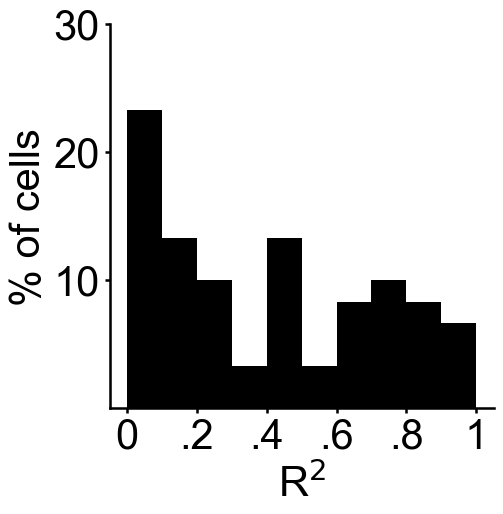

In [126]:
# plot a histogram of r-squared values 
hist_pref = np.histogram(r_sq, bins = np.arange(0,1.1,.1))
plt.bar(np.arange(0,1,.1), (hist_pref[0]/np.sum(hist_pref[0]))*100, width = .1, align = 'edge', color = 'k')
plt.xticks(np.arange(0,1.1,.2), labels = ['0','.2','.4','.6','.8','1'])
plt.ylim(0,25)
plt.yticks([10,20,30])
plt.ylabel('% of cells')
plt.xlabel('R$^2$')
PGanalysis.axis_fixer(ratio = 1, size = 30)

In [127]:
max_resp_by_cell = np.max(mov_mean_y_all,1)

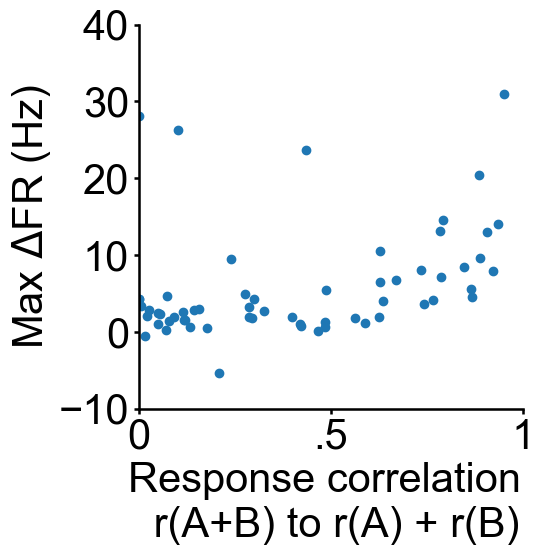

In [128]:
plt.plot(r_sq, max_resp_by_cell, 'o')
plt.xlim(0,1)
plt.xticks([0,.5,1], labels = ['0', '.5', '1'])
plt.yticks([-10,0,10,20,30,40])
plt.xlabel('Response correlation \n r(A+B) to r(A) + r(B)')
plt.ylabel('Max $\Delta$FR (Hz)')
PGanalysis.axis_fixer(ratio = 1, size = 20)

In [175]:
resp_idx

array([], dtype=int64)

In [178]:
np.where(np.array(tuned_resp_cells) == 15)

(array([2], dtype=int64),)

Cell 15 r-squared = 0.9222213570330763
Cell 160 r-squared = 0.9346558634894786
Cell 262 r-squared = 0.9059100040365902
Cell 474 r-squared = 0.628147148721494
Cell 497 r-squared = 0.7873863497592081


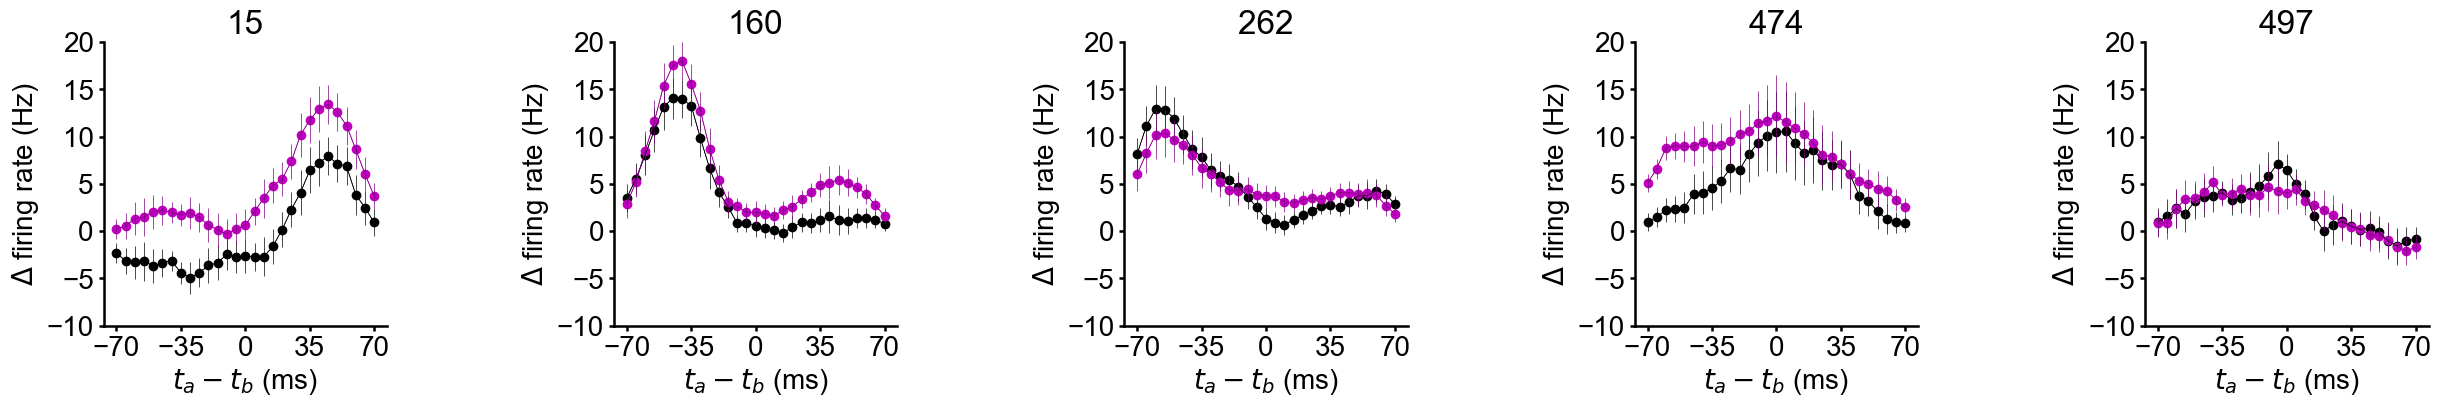

In [184]:
plt.figure(figsize = (30,30))
for cell_n, cell in enumerate([15, 160, 262, 474, 497]):
    plt.subplot(1,5,cell_n+1)
    plot_real_and_predicted_curves(cell, baseline_sub_psth_by_trial, indices, single_spot_indices, n_trials, n_stim, font_size = 20)
    resp_idx = np.where(np.array(tuned_resp_cells) == cell)[0]
    print('Cell ' + str(cell) + ' r-squared = ' + str(r_sq[resp_idx][0]))